# Convolutional Neural Network (CNN) \newline for Wafer Edge Automatic Defect Classification (ADC)

\hrulefill

*NOTE: Lines with # in front are "comments", ie. they are ignored when the code is run*

## Goal
* Predict either of 2 classes: None (No Chipping) or Chipping
  * 0: Represents None
  * 1: Represents Chipping

## Data Collected (Pre-Classified/Sorted Manually)
* 2265 Edge Normal images from Klarity: 2235 None Images and 30 Chipping Images
* 8 images from previous student's ppt slides
* 2574 New Images from Klarity (22 SEP - 5 OCT)

## Breakdown of Dataset
* In Sample Model Training (Training + Validation): 480 Images (240 chipping with duplicates and 240 unique non-chipping)
  * Training (In Sample): 80%
  * Validation (In Sample): 20%
* Out of Sample Model Testing: 4577 Images
  * Testing (Out of Sample): 8 Test images
  * None Testing (Out of Sample): 1995 None images
  * New Testing (Out of Sample): 2574 New images

<div style="page-break-after: always;"></div>

## Model Created
![cnn.png](figures\cnn.png)

* Using deep learning and CNN, the model automatically extracts features from the images and learns to distinguish whether an image fed into the model exhibits signs of chipping or not
  * Each layer (denoted by the circles in above diagram) are just a list of decimal numbers; and many layers together form a multi-dimensional matrix, or "tensor"
  * The input layer is thus the set of decimals obtained from breaking down the images into their RGB values; eg. (255,255,255) is a white pixel
  * These layers go through a lot of mathematical calculations including matrix calculations and differentiations (gradient descent) to produce outputs for the next layers (denoted by the next set of circles through the connected lines)
  * The final layer, the output layer, is a Dense layer and comes along with the number of classes to predict; in our case, Dense(2) is used since there are only 2 classes to predict
  * After reaching the final layer, the process is reversed through a step called backpropagation to reach the input layer again
  * This cycle repeats for as many epochs (or "steps") as specified
* To improve accuracy and speed of model training, transfer learning is used
  * Transfer learning is using models previously created by very smart researchers and machine learning engineers that have then been trained on millions of images such as cats, dogs, etc. 
  * Even though their models were used to classify other kinds of images like animals or vehicles, we can leverage their results for our own use case
  * By cutting off a small part of their model, we can customise their models to classify either wafer chipping or not
* A few popular models available are VGG16, ResNet, Inception, NASNet, YOLO, F-RCNN etc. and they vary in purpose, size, complexity, accuracy, speed, among other things

\pagebreak

## My Folder Structure
```
os.getcwd()                <- "current working directory", the reference folder
|
+-- code                   <- model codes and auto-screenshotting script
|   |
|   \-- figures            <- figures and images found online used in my reports
|
+-- data                   <- all images screenshotted from citrix
|   |
|   +-- klarf-BACKUP       <- copy of all images for backup purposes
|   +-- klarf-map          <- all backside wafer maps
|   +-- klarf-BS           <- all backside images
|   \-- klarf-EN           <- all edge normal (EN) images, "EN_path"
|       |
|       +-- augmented      <- edited images during training to improve model
|       +-- chipping-19oct <- new chipping images of 2 wafers taken on 19 oct
|       +-- new            <- new images of 54 wafers taken from 22 sep - 5 oct
|       +-- test           <- 8 images taken from previous student's ppt
|       \-- trainval       <- 2235 'none' images and 30 'chipping' images
|
+-- models                 <- generated models in .h5 format ready for prediction
+-- prototype              <- early testing phase on online dataset WM-811K
+-- references             <- research papers on ML, CNN, ADC, etc.
+-- reports                <- PDF files of code
|   |
|   \-- notes              <- quick notes on findings, explanations, progress, etc.
|
+-- requirements.txt       <- list of additional python libraries required
\-- results                <- excel/csv files of model testing results
```

\pagebreak

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import os, glob
import time, pytz, datetime
import random
import gc
import matplotlib.pyplot as plt

def duration(start):
    DURATION = round((time.time() - start)/60, 2)
    print(f'\n{DURATION} mins')
    
def timenow():
    current_time = datetime.datetime.now(pytz.timezone('Asia/Singapore')).strftime('%#d%b-%H%M')
    print(current_time)
    return current_time

In [2]:
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, MaxPooling2D
from keras.callbacks import TensorBoard, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
from keras.applications import vgg16

<div style="page-break-after: always;"></div>

## Check if GPU is enabled
My laptop happens to have a GPU called NVIDIA GeForce MX150, a weak GPU but still faster than a CPU because they are specialised hardware for complicated math calculations

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9392604182740288437
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1401755854
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17553392930416796173
physical_device_desc: "device: 0, name: NVIDIA GeForce MX150, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## Setting up some variables
* chipping_len: integer 30, number of chipping images to be used for training/validation
* EN_path: folder that contains all the edge normal (EN) images (refer to above folder structure)

In [5]:
EN_path = os.path.join(os.getcwd(), '..', 'data', 'klarf-EN')
chipping_len = len(glob.glob(os.path.join(EN_path, 'trainval', 'chipping', '*')))
EN_path

'C:\\Users\\ZM\\Desktop\\ssmc\\code\\..\\data\\klarf-EN'

In [6]:
NUM_CLASSES = 2
IMG_SIZE = 256
VAL_SPLIT = 0.2

DEFECT_LIST = ['none', 'chipping']
DEFECT_MAPPING = dict(enumerate(DEFECT_LIST))
DEFECT_MAPPING

{0: 'none', 1: 'chipping'}

In [7]:
BATCH_SIZE = 16

\pagebreak

# Dealing with Lack of Data and Imbalanced Data

\hrulefill

## Why is this a problem?
* Small and imbalanced datasets (majority no-chipping, minority chipping) cause models to be biased towards the majority class
* To combat this, there are a few methods we can employ to either balance the data or increase the generability of the model or both

## Class Imbalance Solutions
1. Undersampling Majority Class (random sampling portion of majority class)
2. Oversampling Minority Class (duplicating minority class)
3. Class Weights (ratio to balance the classes based on quantity)
4. Data Inflation (augmenting existing data to inflate dataset)
5. SMOTE, Synthetic Minority Oversampling Technique (creating "new", synthetic data)
6. Ensemble Voting (multiple models "vote" for a correct answer)
7. Focal Loss (scales loss function to prioritize hard negative examples)

In [6]:
n = 10
x_train, y_train, x_test, y_test, img_paths = [], [], [], [], []

chipping_sample = random.sample(glob.glob(os.path.join(EN_path, 'trainval', 'chipping', '*')), chipping_len)
for i in range(len(chipping_sample)):
    img_paths.append(chipping_sample[i])
    img = Image.open(chipping_sample[i])
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img = np.asarray(img)[:, :, :3]
    if i < len(chipping_sample)*(1-VAL_SPLIT): # train 80% = 24*n
        for j in range(n):
            x_train.append(img)
            y_train.append('chipping')
    else: # val 20% = 6
        x_test.append(img)
        y_test.append('chipping')

none_sample = random.sample(glob.glob(os.path.join(EN_path, 'trainval', 'none', 'none', '*')), chipping_len*n)
for i in range(len(none_sample)):
    img_paths.append(none_sample[i])
    img = Image.open(none_sample[i])
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img = np.asarray(img)[:, :, :3]
    if i < len(none_sample)*(1-VAL_SPLIT):
        x_train.append(img)
        y_train.append('none')
    else:
        x_test.append(img)
        y_test.append('none')

x_train, y_train, x_test, y_test = np.array(x_train, dtype=object), np.asarray(y_train), np.array(x_test, dtype=object), np.asarray(y_test)

p = np.random.permutation(len(x_train))
x_train, y_train = x_train[p], y_train[p]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((480, 256, 256, 3), (480,), (66, 256, 256, 3), (66,))

In [7]:
def encode(y): return np.array([0 if label=='none' else 1 for label in y])

y_train_encoded = encode(y_train)
y_test_encoded = encode(y_test)

from tensorflow.keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

## Image IDs of the non-chipping images used (randomly picked)

In [8]:
print([int(i.split('-')[-1].split('.')[0]) for i in img_paths[30:]])

[1766, 643, 882, 1903, 1550, 620, 1781, 1294, 2202, 1260, 611, 1515, 100, 2203, 235, 1614, 1682, 2249, 771, 414, 1447, 2021, 2096, 1040, 2138, 975, 2, 329, 2092, 1838, 1422, 925, 1109, 938, 1494, 1289, 2224, 632, 219, 1963, 2210, 2055, 79, 546, 1019, 1138, 562, 1961, 553, 1902, 1818, 37, 356, 1799, 673, 317, 1933, 1255, 808, 427, 572, 210, 223, 2003, 363, 4, 246, 1730, 1434, 1900, 550, 627, 1380, 1410, 2015, 884, 1861, 339, 1450, 1243, 1927, 1473, 821, 2109, 1934, 1591, 1686, 1481, 1926, 540, 1327, 1079, 1787, 1424, 1645, 2120, 255, 1699, 2244, 638, 1840, 292, 1941, 654, 666, 2126, 524, 896, 1471, 1003, 992, 1332, 1879, 348, 1654, 1735, 1930, 1684, 1669, 660, 259, 1476, 1187, 671, 1099, 1439, 1344, 408, 288, 1536, 1738, 696, 535, 218, 1570, 177, 1850, 99, 525, 610, 2074, 1887, 589, 1402, 1485, 42, 1612, 564, 254, 871, 1790, 1846, 1230, 1492, 478, 1870, 1679, 2135, 622, 1779, 133, 1072, 1763, 1589, 283, 296, 1173, 1914, 1423, 1966, 2177, 1658, 1169, 1352, 1406, 936, 989, 2170, 1754, 209

<div style="page-break-after: always;"></div>

## Processing using ImageDataGenerator
This will perform changes to the images during training if specified

In [9]:
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     brightness_range=[0.8,1.2],
#     width_shift_range=0.15,
#     height_shift_range=0.15,
#     fill_mode='constant',
#     cval=1.00,
#     shear_range=0.2,
#     zoom_range=[0.7,1.3],
    vertical_flip=True,
    horizontal_flip=True,
    preprocessing_function=vgg16.preprocess_input,
)

train_generator = train_datagen.flow(
    x=x_train,
    y=y_train_one_hot,
    batch_size=BATCH_SIZE,
    shuffle=True,
#     save_to_dir=os.path.join(os.getcwd(), 'klarf-EN', 'augmented')
)

val_generator = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input).flow(
    x=x_test,
    y=y_test_one_hot,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

In [8]:
gc.collect()

124

\pagebreak

# Load and Customise Pretrained Model and Train Model

\hrulefill

## Pretrained Model Used: VGG16
![vgg16.png](figures\vgg16.png)

* VGG16 achieved 92.7% top-5 test accuracy^ on ImageNet, which is a dataset of over 14million images belonging to 1000 classes
  * ^Top-5 accuracy is the accuracy of getting the correct prediction within the top 5 predictions (the 5 out of 1000 predictions with the highest probabilities)
* This model is also not too complex or big, which might help with understanding the model and also fitting the model to our problem

## Customising VGG16
![vgg16-flat.jpeg](figures\vgg16-flat.jpeg)

* By removing the 'top' layers (the green blocks), we can customise the model to our own needs
* This is because the final dense layer (just before => Output), is the layer that controls how many classes the model is predicting
* So the original final dense layer was a Dense(1000) layer because it was predicting 1000 classes instead of 2 for our case

<div style="page-break-after: always;"></div>


In [11]:
pretrained_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

PRETRAINED_NAME = pretrained_model.name

for layer in pretrained_model.layers: 
    layer.trainable = False

pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [12]:
#------------------------------- Hyperparameters ------------------------------#

DENSE_LAYER_SIZE = 32
DROPOUT = 0.2

#---------------------------- Layer Customisations ----------------------------#

x = pretrained_model.output

x = Flatten()(x)
x = Dense(DENSE_LAYER_SIZE, activation='relu', kernel_initializer='he_uniform')(x)
x = Dropout(DROPOUT)(x)
x = Dense(2, activation='softmax')(x)

cnn_model = Model(inputs=pretrained_model.input, outputs=x)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# cnn_model = load_model('models\\model_loss.h5')

13Oct-1845
Epoch 1/50
30/30 [==============================] - 49s 725ms/step - loss: 1.6693 - accuracy: 0.8479 - val_loss: 0.0087 - val_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.00872, saving model to models\model_loss.h5

Epoch 00001: loss improved from inf to 1.66928, saving model to models\model_loss2.h5
Epoch 2/50
30/30 [==============================] - 16s 524ms/step - loss: 0.2533 - accuracy: 0.9563 - val_loss: 0.3725 - val_accuracy: 0.9545

Epoch 00002: val_loss did not improve from 0.00872

Epoch 00002: loss improved from 1.66928 to 0.25331, saving model to models\model_loss2.h5
Epoch 3/50
30/30 [==============================] - 16s 523ms/step - loss: 0.1465 - accuracy: 0.9833 - val_loss: 0.0142 - val_accuracy: 0.9848

Epoch 00003: val_loss did not improve from 0.00872

Epoch 00003: loss improved from 0.25331 to 0.14648, saving model to models\model_loss2.h5
Epoch 4/50
30/30 [==============================] - 15s 493ms/step - loss: 0.0547 - accuracy: 0.9

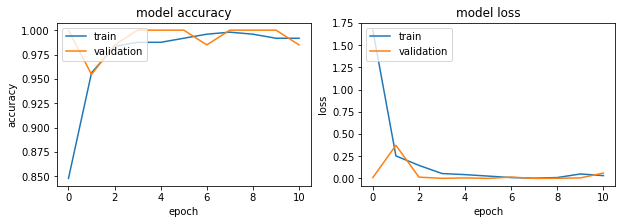


3.41 mins


In [13]:
DATETIME = timenow()
start = time.time()

#------------------------ Model Callbacks and Model Fit -----------------------#

PATIENCE = 5
earlystop = EarlyStopping(monitor='val_loss', patience=PATIENCE)
lr_stagnate = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1, mode='auto')
checkpoint_loss = ModelCheckpoint('../models/model_loss.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
checkpoint_loss2 = ModelCheckpoint('../models/model_loss2.h5', monitor='loss', verbose=1, save_best_only=True, mode='auto')
checkpoint_acc = ModelCheckpoint('../models/model_acc.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

#------------------------------- Model Training -------------------------------#

hist = cnn_model.fit(train_generator, epochs=50, validation_data=val_generator, callbacks=[checkpoint_loss, checkpoint_loss2, earlystop])

#-------------------------- Training/Validation Curves ------------------------#

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

# Plot training and validation accuracy against epochs using matplotlib
ax1.plot(hist.history['accuracy'])
ax1.plot(hist.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')

# Plot training and validation loss against epochs using matplotlib
ax2.plot(hist.history['loss'])
ax2.plot(hist.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper left')

plt.show()

#------------------------------------------------------------------------------#

EPOCHS = len(hist.history['val_loss']) - PATIENCE
duration(start)

\pagebreak

# Using Trained Model to do Predictions

\hrulefill

* Training/Validation accuracies will generally be high as the model has seen these images before
* Test (out of sample) images will be more reflective of how the model will predict new images
* There are also ~2000 None images that are unused during training/vaidation that can further give insights into the model's performance

## Confusion Matrix
![confusion-matrix.png](figures\confusion-matrix.png)

* TN (True Negative): Correct predictions of non-chipping
* TP (True Positive): Correct predictions of chipping
* FP (False Positive): Wrongly predicted chipping when it's suppposed to be non-chipping
* FN (False Negative): Wrongly predicted non-chipping when it's supposed to be chipping

## Load Model

In [10]:
# model = load_model('../models/model_loss.h5')
model = load_model('../models/vgg16_13Oct-1845.h5')
# model = cnn_model

## Save Model

In [15]:
NAME = f'{PRETRAINED_NAME}_{DATETIME}'
model.save(os.path.join(os.getcwd(), 'models', f'{NAME}.h5'))

## Validation Accuracy

5/5 [==============================] - 2s 413ms/step


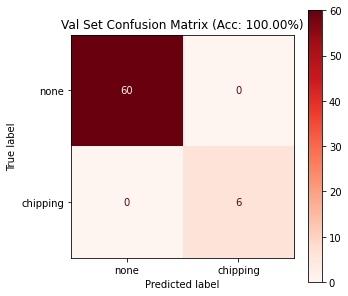

100.00%


In [17]:
val_pred = model.predict(val_generator, verbose=1)
val_pred = np.argmax(val_pred, axis=1).tolist()
val_acc = (y_test_encoded == val_pred).sum() / y_test_encoded.size

cm = confusion_matrix(y_test_encoded, val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=DEFECT_LIST)
fig, ax = plt.subplots(figsize=(5,5))
ax.set_title(f'Val Set Confusion Matrix (Acc: {val_acc:.2%})')
disp.plot(cmap=plt.cm.Reds, ax=ax)
plt.show()

val_generator.reset()

## Training Accuracy

60/60 [==============================] - 21s 353ms/step


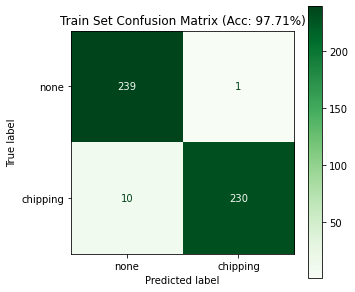

In [19]:
train_pred = model.predict(np.asarray(x_train).astype('float32'), batch_size=BATCH_SIZE//2, verbose=1)
train_pred = np.argmax(train_pred, axis=1).tolist()
train_acc = (y_train_encoded == train_pred).sum() / y_train_encoded.size

cm = confusion_matrix(y_train_encoded, train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=DEFECT_LIST)
fig, ax = plt.subplots(figsize=(5,5))
ax.set_title(f'Train Set Confusion Matrix (Acc: {train_acc:.2%})')
disp.plot(cmap=plt.cm.Greens, ax=ax)
plt.show()

## Single Image Accuracy

[100] The prediction for this image is: none (0)


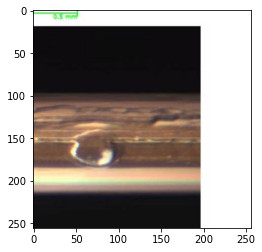

In [33]:
testimg = glob.glob(os.path.join(EN_path, 'trainval', 'none', 'none', '*'))[100] #69
testimg = Image.open(testimg)
testimg = testimg.resize((IMG_SIZE, IMG_SIZE))
testimg = np.asarray(testimg)
plt.imshow(testimg)

testimg = vgg16.preprocess_input(testimg)

testimg = np.expand_dims(testimg, axis=0)
testpred_raw = model.predict(testimg)
testpred = np.argmax(testpred_raw, axis=1)
print(f"[{100}] The prediction for this image is: {DEFECT_MAPPING.get(testpred[0])} ({testpred[0]})")

In [34]:
testpred_raw

array([[0.9999958 , 0.00000413]], dtype=float32)

In [44]:
pd.DataFrame(testpred_raw, columns=DEFECT_LIST)

,none,chipping
0,0.999996,0.000004


In [46]:
np.max(testpred_raw)

0.9999958

## PPT Test Accuracy
Testing on the 8 images extracted from the ppt to simulate new images coming in

In [11]:
test_generator = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input).flow_from_directory(
    directory=os.path.join(EN_path, 'test'),
    classes=DEFECT_LIST,
    class_mode='categorical',
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE//2,
    shuffle=False,
)
test_generator.labels

Found 8 images belonging to 2 classes.


array([0, 0, 0, 1, 1, 1, 1, 1])

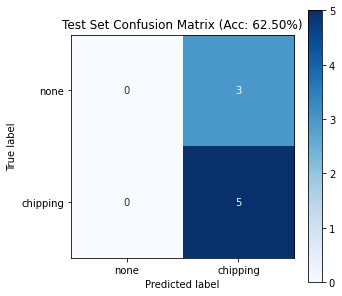

[1, 1, 1, 1, 1, 1, 1, 1]

In [13]:
test_preds_raw = model.predict(test_generator)
test_preds = np.argmax(test_preds_raw, axis=1).tolist()
test_acc = (test_generator.labels == test_preds).sum() / len(test_preds)

cm = confusion_matrix(test_generator.labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=DEFECT_LIST)
fig, ax = plt.subplots(figsize=(5,5))
ax.set_title(f'Test Set Confusion Matrix (Acc: {test_acc:.2%})')
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

test_generator.reset()
test_preds

In [15]:
np.set_printoptions(suppress=True)
test_preds_raw

array([[0.00000039, 0.99999964],
       [0.00000031, 0.99999964],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]], dtype=float32)

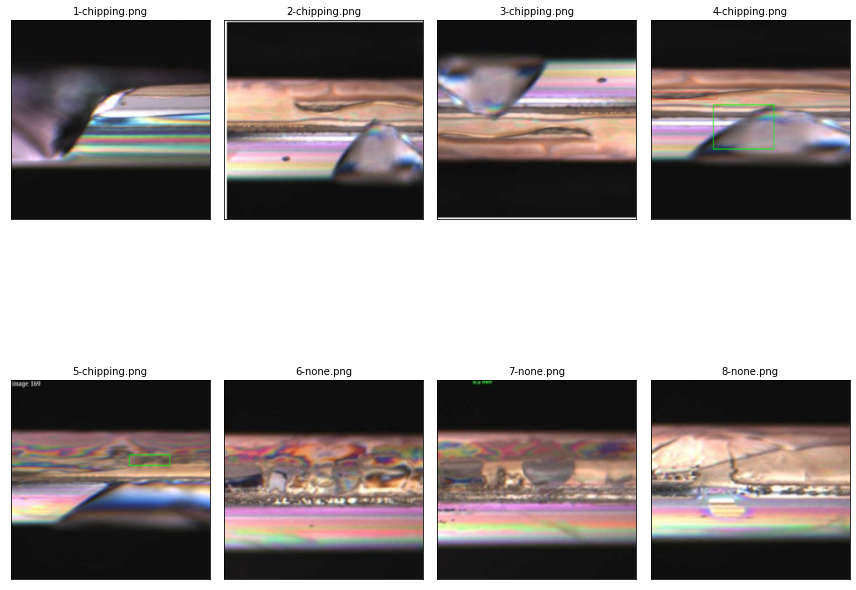

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 12))
ax = ax.ravel(order='C')
all_test_imgs = glob.glob(os.path.join(EN_path, 'test', 'chipping', '*')) + glob.glob(os.path.join(EN_path, 'test', 'none', '*'))
for i in range(len(all_test_imgs)):
    img = Image.open(all_test_imgs[i])
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img = np.asarray(img)
    ax[i].imshow(img)
    title = all_test_imgs[i].split('\\')[-1]
    ax[i].set_title(title, fontsize=10)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show()

## None Images Accuracy
Testing on all the 2235 None images, so the predictions should be all 0s (all no chipping)

In [16]:
none_generator = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input).flow_from_directory(
    directory=os.path.join(EN_path, 'trainval', 'none'),
    class_mode=None,
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE//2,
    shuffle=False,
)

Found 2235 images belonging to 1 classes.


In [17]:
start = time.time()
none_preds_raw = model.predict(none_generator, verbose=1)
none_preds = np.argmax(none_preds_raw, axis=1).tolist()
none_generator.reset()
none_acc = 1-sum(none_preds)/(len(none_preds))
print(f'{none_acc:.2%}')
duration(start)

280/280 [==============================] - 120s 427ms/step
100.00%

2.1 mins


In [31]:
maxed = np.max(none_preds_raw, axis=1)
[m for m in range(len(maxed)) if maxed[m] < 0.9]
# none_preds_raw[939]

[634, 939]

In [33]:
none_incorrects = [i for i in range(len(none_preds)) if none_preds[i] == 1]
print(none_incorrects, len(none_incorrects), len(none_preds)-len(none_incorrects), len(none_preds))

[] 0 2235 2235


In [ ]:
fig, ax = plt.subplots(nrows=len(none_incorrects)//6+1, ncols=6, figsize=(12, 12))
ax = ax.ravel(order='C')
for a in ax: a.set_axis_off()
i = 0
for none_img in glob.glob(os.path.join(EN_path, 'none', 'none', '*')):
    if int(none_img.split('-')[-1].split('.')[0]) in none_incorrects:
        img = Image.open(none_img)
        img = img.resize((IMG_SIZE, IMG_SIZE))
        img = np.asarray(img)
        ax[i].imshow(img)
        ax[i].set_axis_on()
        ax[i].set_title(f'wafer-{none_img.split("-")[-1]}', fontsize=10)
        ax[i].set_xlabel('none', fontsize=10)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        i += 1

plt.tight_layout()
plt.show()

## New Images Accuracy
Testing on 2574 new images taken from 54 wafers in Klarity between 22 SEP - 5 OCT  
Unfortunately, there are only 4 chipping images, image IDs [5763, 5764, 6824, 6825]

In [35]:
# chipping = [5763, 5764, 6824, 6825]

new_chipping = []
for path in glob.glob(os.path.join(EN_path, 'new', 'chipping', '*')):
    img = Image.open(path)
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img = np.asarray(img)
    new_chipping.append(img)
        
new_chipping = np.asarray(new_chipping)
new_chipping = vgg16.preprocess_input(new_chipping)
new_chipping.shape

(4, 256, 256, 3)

In [36]:
new_cp_pred = model.predict(new_chipping)
new_cp_pred = np.argmax(new_cp_pred, axis=1).tolist()
print(f'{sum(new_cp_pred)/len(new_chipping):.2%}')

75.00%


In [37]:
new_generator = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input).flow_from_directory(
    directory=os.path.join(EN_path, 'new'),
    classes=DEFECT_LIST,
    class_mode='categorical',
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE//2,
    shuffle=False,
)

Found 2574 images belonging to 2 classes.


322/322 [==============================] - 148s 461ms/step


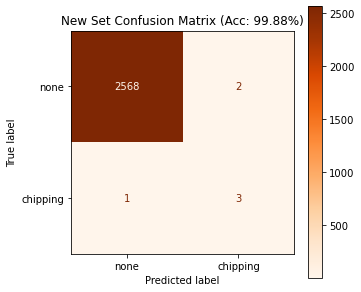


2.49 mins


In [39]:
start = time.time()
new_preds = model.predict(new_generator, verbose=1)
new_preds = np.argmax(new_preds, axis=1).tolist()
new_acc = (new_generator.labels == new_preds).sum() / len(new_preds)

cm = confusion_matrix(new_generator.labels, new_preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=DEFECT_LIST)
fig, ax = plt.subplots(figsize=(5,5))
ax.set_title(f'New Set Confusion Matrix (Acc: {new_acc:.2%})')
disp.plot(cmap=plt.cm.Oranges, ax=ax)
plt.show()

new_cp_acc = cm[1,1]/4
new_generator.reset()
duration(start)

In [40]:
new_incorrects = [i+5756 for i in range(len(new_preds)) if new_preds[i] != new_generator.labels.tolist()[i]]
print(new_incorrects, len(new_incorrects), len(new_preds)-len(new_incorrects), len(new_preds))

[5797, 8227, 8326] 3 2571 2574


\pagebreak

# Saving Results to Excel (CSV Format)

\hrulefill

For my own understanding and recording purposes to track changes in experiments and parameters

## Overwrite Results

In [41]:
df_results = pd.DataFrame(columns=[
    "name", 
    "datetime", 
    "pretrained_model", 
    "val_loss", 
    "train_acc", 
    "val_acc", 
    "test_acc", 
    "none_acc", 
    "new_acc", 
    "new_cp_acc", 
    "n_sampling", 
    "img_size", 
    "batch_size", 
    "epochs", 
    "dense_layers", 
    "dense_layer_size", 
    "dropout", 
])
df_results

,name,datetime,pretrained_model,val_loss,train_acc,val_acc,test_acc,none_acc,new_acc,new_cp_acc,n_sampling,img_size,batch_size,epochs,dense_layers,dense_layer_size,dropout


## Load and Update Results

In [ ]:
df_results = pd.read_csv('../results/edge-results.csv')
df_results.tail(3)

In [42]:
df_results = df_results.append({
    "name": NAME,
    "pretrained_model": PRETRAINED_NAME, 
    "datetime": DATETIME, 
    "val_loss": min(hist.history['val_loss']), 
    "train_acc": train_acc, 
    "val_acc": val_acc, 
    "test_acc": test_acc, 
    "none_acc": none_acc, 
    "new_acc": new_acc, 
    "new_cp_acc": new_cp_acc, 
    "n_sampling": n, 
    "img_size": IMG_SIZE, 
    "batch_size": BATCH_SIZE, 
    "epochs": EPOCHS, 
    "dense_layers": 1, 
    "dense_layer_size": DENSE_LAYER_SIZE, 
    "dropout": DROPOUT, 
}, ignore_index=True)

df_results.to_csv('../results/edge-results.csv', index=None)
df_results.tail(3)

,name,datetime,pretrained_model,val_loss,train_acc,val_acc,test_acc,none_acc,new_acc,new_cp_acc,n_sampling,img_size,batch_size,epochs,dense_layers,dense_layer_size,dropout
0,vgg16_13Oct-1845,13Oct-1845,vgg16,0.000003,0.977083,1.0,0.625,1.0,0.998834,0.75,10,256,16,6,1,32,0.2
